In [1]:
from IPython.display import display

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from copy import deepcopy
import sys

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sys.path.insert(1,'../')

In [3]:
from data.dataset import ShopDataset
from model.forecaster import Forecaster

In [4]:
df = pd.read_csv("../data/sales-info.csv.gz")

In [5]:
df.head()

,documentDate,DocumnetNumber,ItemCode,PaymentTerm,Quantity,Region
0,2015-01-01,INV017109010,PF0084103,30 Days,4,Region 5
1,2015-01-01,INV017109010,TT0010103,30 Days,5,Region 5
2,2015-01-01,INV017109010,WF8060101,30 Days,12,Region 5
3,2015-01-01,INV024111613,GF4501101,30 Days,60,Region 3
4,2015-01-01,INV015810027,GF4501101,Cash,12,Region 10


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195773 entries, 0 to 1195772
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   documentDate    1195773 non-null  object
 1   DocumnetNumber  1195773 non-null  object
 2   ItemCode        1195773 non-null  object
 3   PaymentTerm     1160747 non-null  object
 4   Quantity        1195773 non-null  int64 
 5   Region          1122485 non-null  object
dtypes: int64(1), object(5)
memory usage: 54.7+ MB


In [7]:
df.describe()

,Quantity
count,1.195773e+06
mean,4.721201e+01
std,4.038206e+02
min,0.000000e+00
25%,6.000000e+00
50%,1.200000e+01
75%,3.000000e+01
max,1.000000e+05


In [8]:
datetime_info = pd.to_datetime(df['documentDate']).describe().to_dict()

In [9]:
datetime_info

{'count': 1195773,
 'unique': 361,
 'top': Timestamp('2015-11-30 00:00:00'),
 'freq': 6353,
 'first': Timestamp('2015-01-01 00:00:00'),
 'last': Timestamp('2015-12-31 00:00:00')}

In [10]:
unique_counts = df.nunique().to_dict()

In [11]:
unique_counts

{'documentDate': 361,
 'DocumnetNumber': 651748,
 'ItemCode': 37,
 'PaymentTerm': 17,
 'Quantity': 1117,
 'Region': 12}

In [12]:
df.isna().sum()

documentDate          0
DocumnetNumber        0
ItemCode              0
PaymentTerm       35026
Quantity              0
Region            73288
dtype: int64

## Little-bit about dataset.
 - This is shop sales dataset in year 2015. Includes both invoice and return records. First two letters of the item code represent the item category.

In [13]:
f"There are {len(df):,} records in dataset from {datetime_info['first']} to {datetime_info['last']}. There are {unique_counts['ItemCode']} unique item available"

'There are 1,195,773 records in dataset from 2015-01-01 00:00:00 to 2015-12-31 00:00:00. There are 37 unique item available'

 - `GOAL`: Build a demand forecasting model for each region-product pair in the dataset
 - Let's remove all records with `null` region info

In [14]:
df.dropna(subset=['Region'],inplace=True)

In [15]:
df.shape

(1122485, 6)

create `product_category` column

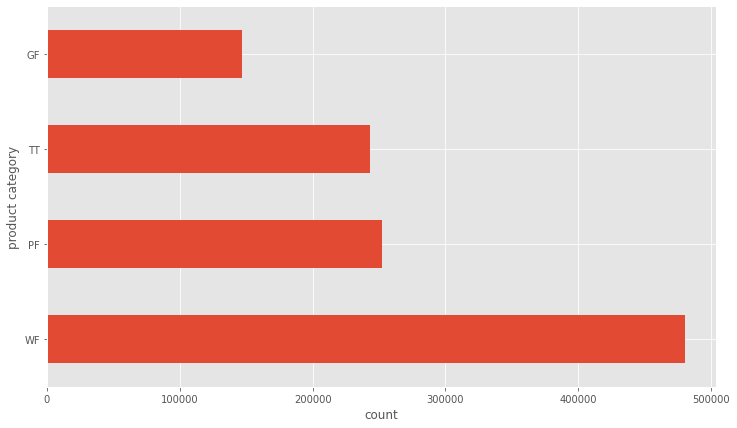

In [16]:
df['productCategory'] = df['ItemCode'].apply(lambda x:x[:2])

df['productCategory'].value_counts().plot.barh(figsize=(12,7))
plt.xlabel("count")
plt.ylabel("product category")
plt.show()

Let's build `ShopDataset`
 - ShopDataset - This will build seperate datset for each region-product pair, This includes the outlier removal as well

In [17]:
?ShopDataset

Init signature: ShopDataset(data, region_column, product_col, date_column, target_col) -> None
Docstring:      The dataset class
Init docstring:
data: pandas dataframe including all information of invoice sales/return 
region_column: this is the column name related to the regions in the dataset
product_col: this is the column name related to the product categpry in the dataset
date_column: time stamp column in the dataset
target_col: the column name, that we are going to forecast
File:           ~/store-sales-prediction/data/dataset.py
Type:           type
Subclasses:     


In [18]:
dataset = ShopDataset(
    data=df,
    region_column='Region',
    product_col='productCategory',
    date_column='documentDate',
    target_col='Quantity'
    )

Let's call `define_regional_datasets` method. Under the hood this will use `pd.pivot_table` to create seperate datasets for each `region-product` pair

In [19]:
dataset.define_regional_datasets()

100%|██████████| 12/12 [00:01<00:00, 11.90it/s]


In [20]:
#ex.
dataset.region_10_data.head()

productCategory,GF,PF,TT,WF
documentDate,,,,
2015-01-01,72.0,512.0,0.0,314.0
2015-01-02,30.0,1659.0,0.0,87.0
2015-01-03,66.0,1052.0,0.0,539.0
2015-01-04,0.0,51.0,0.0,100.0
2015-01-05,0.0,2092.0,0.0,0.0


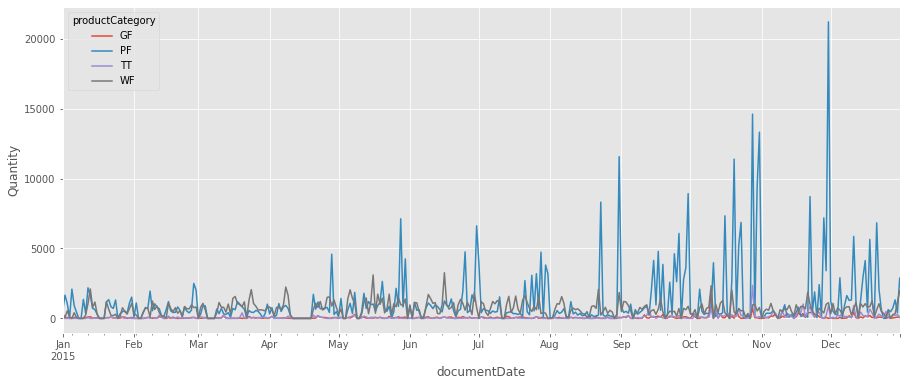

In [21]:
dataset.region_10_data.plot(figsize=(15,6))
plt.ylabel("Quantity")
plt.show()

Since each product have diferent demand plet's plot each product induvudually 

In [22]:
def plot_regional_dataset(data):
    df = deepcopy(data)
  
    _,ax = plt.subplots(nrows=df.shape[1],figsize=(15,8*df.shape[1]))

    for i,product in enumerate(df.columns):
        df[product].plot(ax=ax[i],color='#f25f0a')
        ax[i].set_title(f"{product} sales in given region",fontweight='semibold')
        ax[i].set_ylabel("demand")
    plt.show()

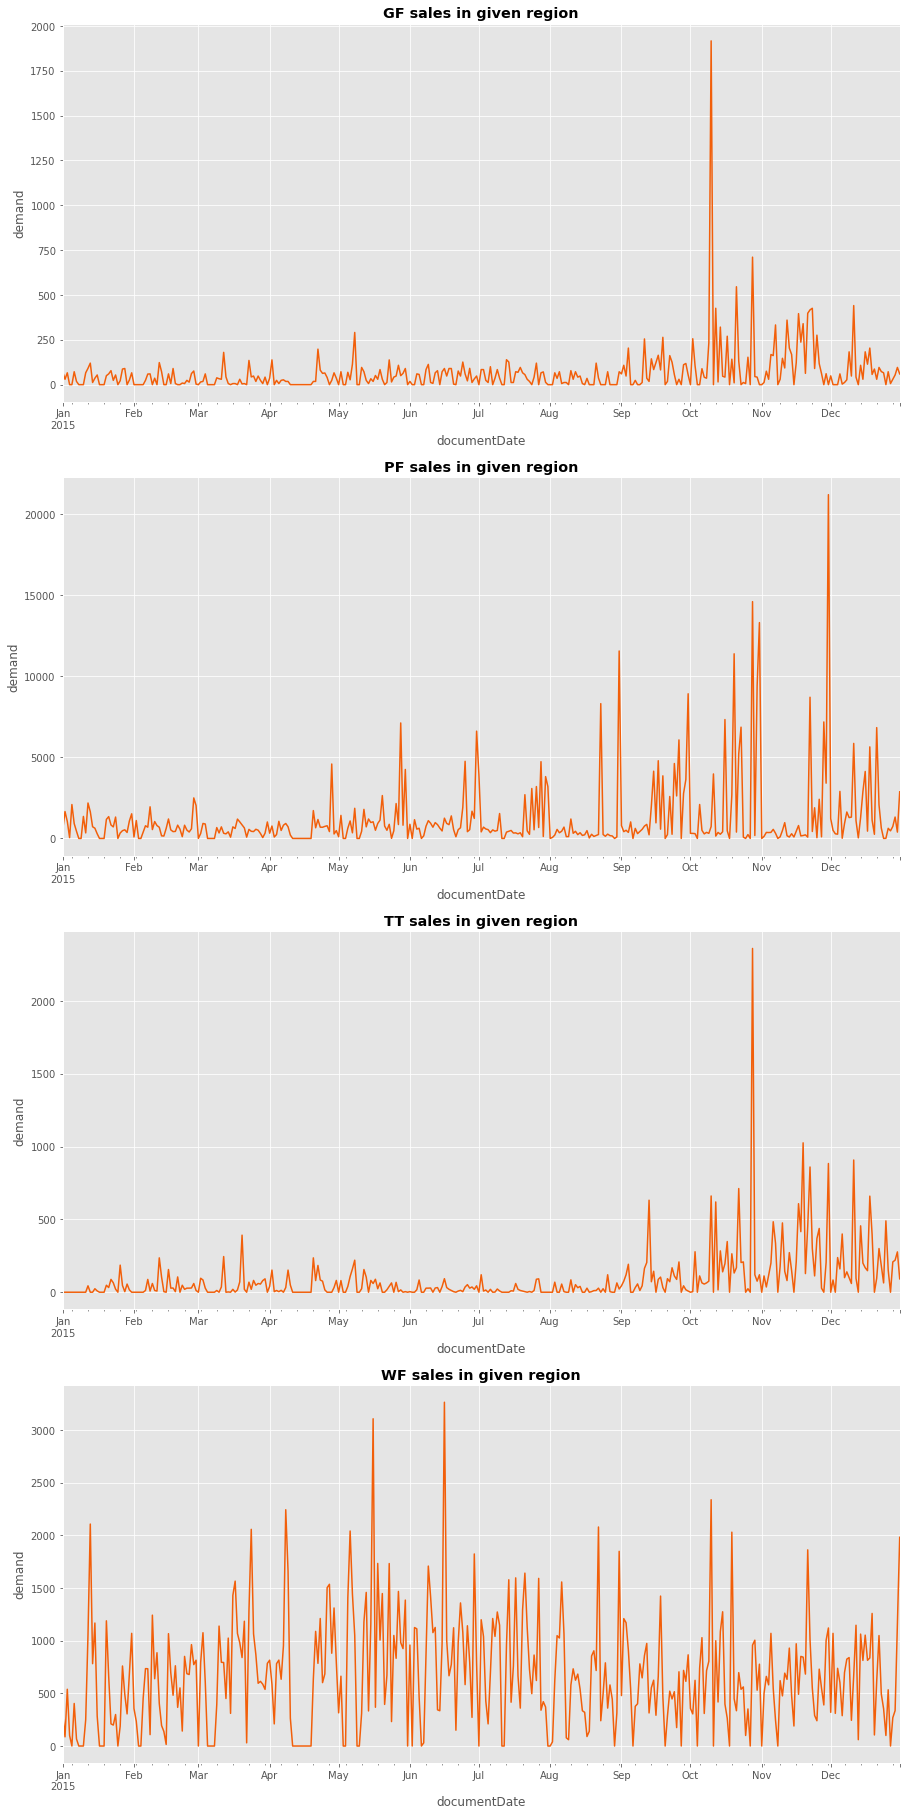

In [23]:
plot_regional_dataset(dataset.region_10_data)

In [24]:
def plot_product_contribution(dataset):
    df = deepcopy(dataset)

    _,ax = plt.subplots(3,4,figsize=(15,2*8))
    axi = ax.flatten()

    regional_datasets = (getattr(dataset,f"region_{i+1}_data") for i in range(len(dataset.regions)) )
    for i,region_df in enumerate(regional_datasets):
        region_pct = region_df.sum()
        axi[i].pie(region_pct,labels=region_pct.index,autopct='%.2f')
        axi[i].set_title(f"Region {i+1}")

    plt.suptitle(f"Product sales distribution in each region".upper(),fontweight='bold',)
    plt.tight_layout()
    plt.show()

## How each product distributed accros each region?

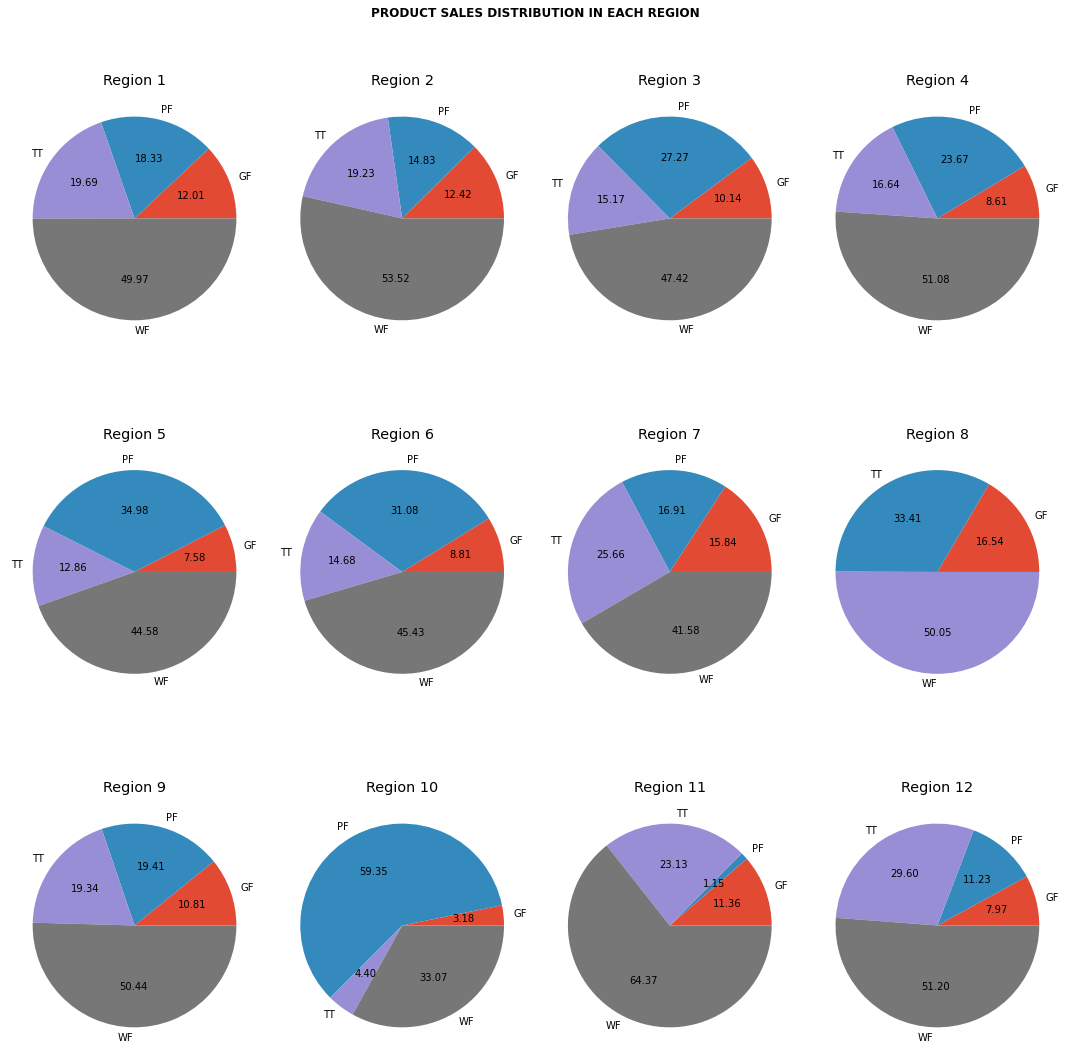

In [25]:
plot_product_contribution(dataset)

## How each region contibuted to sales?

In [26]:
def plot_region_contribution(dataset):
    df = deepcopy(dataset)
    
    region_map = map(lambda x:x.replace(" ","_").lower(),dataset.regions)
    region_revenue_map = {}
    for i,region in enumerate(region_map):
        regional_dataset = getattr(dataset,f"{region}_data")
        region_pct = regional_dataset.sum().sum()
        region_revenue_map[region] = region_pct

    plt.figure(figsize=(8,8))
    plt.pie(region_revenue_map.values(),labels=region_revenue_map.keys(),autopct='%.2f')
    plt.title(f"Region contibution to sales".upper(),fontweight='bold')

    plt.tight_layout()
    plt.show()

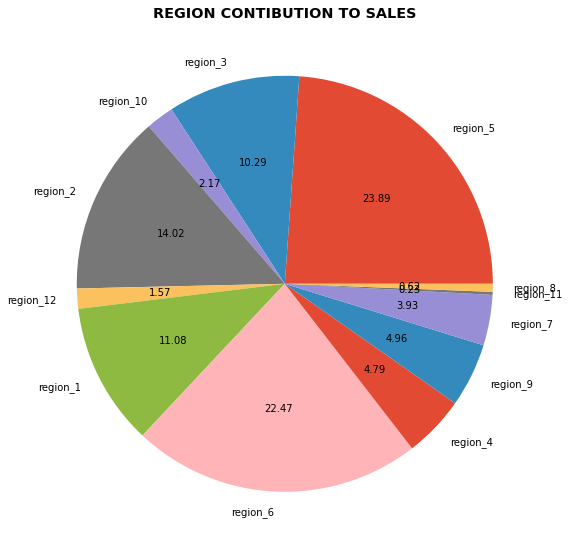

In [27]:
plot_region_contribution(dataset)

## Region seles count behaviour by weekday, month

In [28]:
df['dayName'] = pd.to_datetime(df['documentDate']).dt.day_name()
df['Month'] = pd.to_datetime(df['documentDate']).dt.month_name()

In [29]:
df['Day'] = pd.to_datetime(df['documentDate']).dt.day

In [30]:
month_vs_region_sales = pd.pivot_table(data=df,index='Month',columns='Region',values='Quantity',aggfunc=sum)
day_vs_region_sales = pd.pivot_table(data=df,index='dayName',columns='Region',values='Quantity',aggfunc=sum)

In [31]:
sns.set_style('whitegrid')

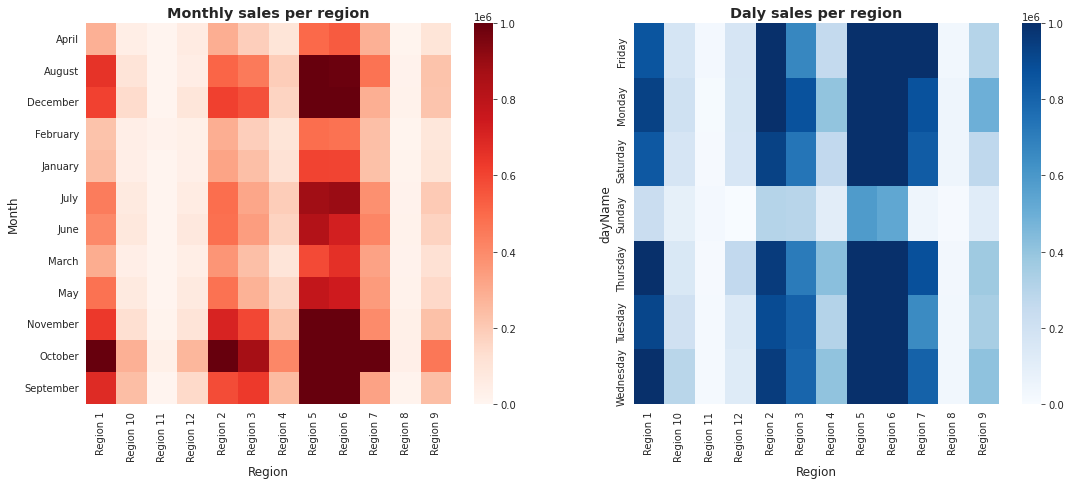

In [32]:
_,ax = plt.subplots(1,2,figsize=(18,7))

sns.heatmap(month_vs_region_sales,cmap='Reds',vmin=0,vmax=1e6,ax=ax[0])
sns.heatmap(day_vs_region_sales,cmap='Blues',vmin=0,vmax=1e6,ax=ax[1])

ax[0].set_title("Monthly sales per region",fontweight='bold')
ax[1].set_title("Daly sales per region",fontweight='bold')
plt.show()

### Key insights
 - `Region 11 & Region 8` shows lower performance compaire to the other regions
 - For most regions, `Sunday` seems to be off day
 - There are very low sales for `February to January`
 - `Regions 6 & 5` and `Regions 1 & 2` show identical behaviour

### Additionaly I need to know day vs sales for each region. To identify pay day effects

In [33]:
day_sales = pd.pivot_table(data=df,columns='Day',index='Region',values='Quantity',aggfunc=sum,fill_value=0)

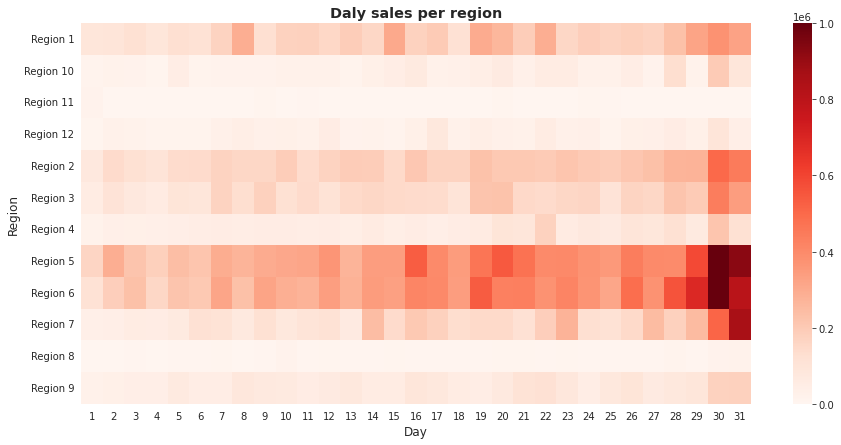

In [34]:
plt.figure(figsize=(15,7))
sns.heatmap(day_sales,cmap='Reds',vmin=0,vmax=1e6)

plt.title("Daly sales per region",fontweight='bold')
plt.show()

We can see high sales in `29,28 & 30 th of each month`

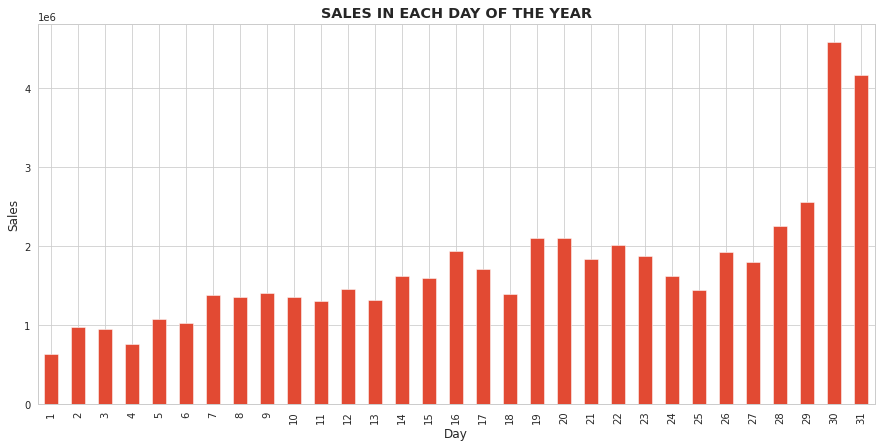

In [35]:
plt.figure(figsize=(15,7))
day_sales.sum().plot.bar()
plt.ylabel("Sales")
plt.title("sales in each day of the year".upper(),fontweight='bold')
plt.show()

## Modeling

In [36]:
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [37]:
forecaster = Forecaster(dataset=dataset,holidays=None,test_size=0.1)
forecaster.fit(include_history=False)

  0%|          | 0/12 [00:00<?, ?it/s]18:34:04 - cmdstanpy - INFO - Chain [1] start processing
18:34:04 - cmdstanpy - INFO - Chain [1] done processing
18:34:04 - cmdstanpy - INFO - Chain [1] start processing
18:34:04 - cmdstanpy - INFO - Chain [1] done processing
18:34:04 - cmdstanpy - INFO - Chain [1] start processing
18:34:05 - cmdstanpy - INFO - Chain [1] done processing
18:34:05 - cmdstanpy - INFO - Chain [1] start processing
18:34:05 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:01<00:21,  1.97s/it]18:34:05 - cmdstanpy - INFO - Chain [1] start processing
18:34:06 - cmdstanpy - INFO - Chain [1] done processing
18:34:06 - cmdstanpy - INFO - Chain [1] start processing
18:34:06 - cmdstanpy - INFO - Chain [1] done processing
18:34:06 - cmdstanpy - INFO - Chain [1] start processing
18:34:07 - cmdstanpy - INFO - Chain [1] done processing
18:34:07 - cmdstanpy - INFO - Chain [1] start processing
18:34:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋     

In [38]:
def plot_predictions(forecaster,region,cat):
    forecaster = deepcopy(forecaster)
    forecast = forecaster.results[region][cat]['forecast']
    error = forecaster.results[region][cat]['error']
    test = forecaster.results[region][cat]['test']
    test.set_index("ds",inplace=True)
    yhat_lower = forecast['yhat_lower']
    yhat_upper = forecast['yhat_upper']
    yhat = forecast['yhat']
    ds = forecast['ds']

    plt.figure(figsize=(15,7))
    plt.plot(ds,yhat,label='predictions')
    plt.fill_between(x=ds,y1=yhat_lower,y2=yhat_upper,color='gray', alpha=0.2)
    plt.plot(test['y'],label='True')
    plt.xticks(pd.date_range(min(ds),max(ds),periods=10))
    plt.legend(loc='upper right')
    plt.text(x=ds[0],y=max(yhat_upper),s=f"Mean Absulte Error: {error:.1f}",backgroundcolor='y')
    plt.title(f"Predictions vs. real data ({region}:{cat})".upper(),fontweight='semibold')
    plt.show()

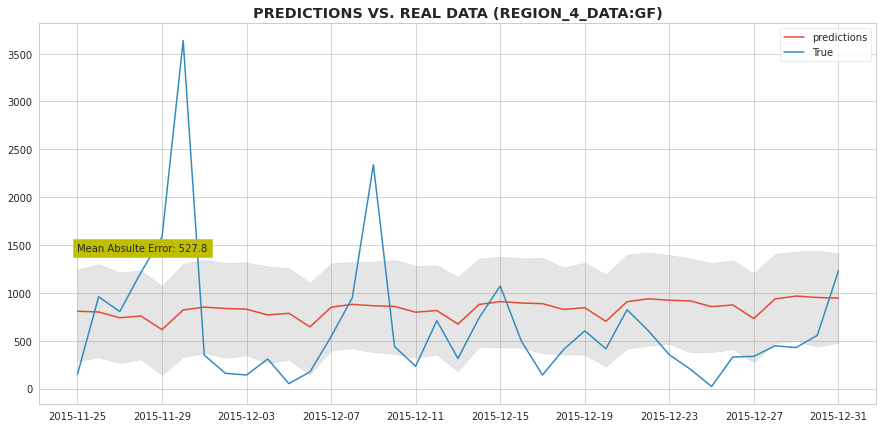

In [39]:
plot_predictions(forecaster,'region_4_data','GF')

### Adding holiday infomation

In [40]:
from datetime import date, timedelta

def all_sundays(year):
    dt = date(year, 1, 1)     
    dt += timedelta(days = 6 - dt.weekday())  
    while dt.year == year:
        yield dt
        dt += timedelta(days = 7)

In [41]:
sundays = []
_ = [sundays.extend(list(all_sundays(year))) for year in [2015,2016,2017,2018,2019,2020]]

sundays = pd.DataFrame({
  'holiday': 'sunday',
  'ds': pd.to_datetime(sundays),
  'lower_window': 0,
  'upper_window': 1,
})

In [42]:
forecaster = Forecaster(dataset=dataset,holidays=sundays,test_size=0.1)
forecaster.fit(include_history=False)

  0%|          | 0/12 [00:00<?, ?it/s]18:34:29 - cmdstanpy - INFO - Chain [1] start processing
18:34:29 - cmdstanpy - INFO - Chain [1] done processing
18:34:30 - cmdstanpy - INFO - Chain [1] start processing
18:34:30 - cmdstanpy - INFO - Chain [1] done processing
18:34:31 - cmdstanpy - INFO - Chain [1] start processing
18:34:31 - cmdstanpy - INFO - Chain [1] done processing
18:34:32 - cmdstanpy - INFO - Chain [1] start processing
18:34:32 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:02<00:32,  2.96s/it]18:34:32 - cmdstanpy - INFO - Chain [1] start processing
18:34:32 - cmdstanpy - INFO - Chain [1] done processing
18:34:33 - cmdstanpy - INFO - Chain [1] start processing
18:34:33 - cmdstanpy - INFO - Chain [1] done processing
18:34:34 - cmdstanpy - INFO - Chain [1] start processing
18:34:34 - cmdstanpy - INFO - Chain [1] done processing
18:34:35 - cmdstanpy - INFO - Chain [1] start processing
18:34:35 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋     

- Testing model

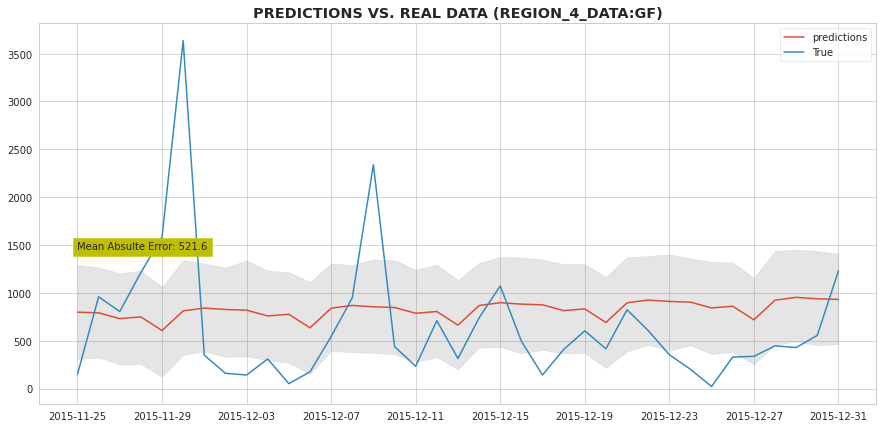

In [43]:
plot_predictions(forecaster,'region_4_data','GF')

### Added country holidays to the model

In [44]:
forecaster = Forecaster(dataset=dataset,holidays=sundays,test_size=0.1)
forecaster.fit(include_history=False,weekly_seasonality='auto',yearly_seasonality=False)

  0%|          | 0/12 [00:00<?, ?it/s]18:35:07 - cmdstanpy - INFO - Chain [1] start processing
18:35:07 - cmdstanpy - INFO - Chain [1] done processing
18:35:08 - cmdstanpy - INFO - Chain [1] start processing
18:35:08 - cmdstanpy - INFO - Chain [1] done processing
18:35:08 - cmdstanpy - INFO - Chain [1] start processing
18:35:08 - cmdstanpy - INFO - Chain [1] done processing
18:35:09 - cmdstanpy - INFO - Chain [1] start processing
18:35:09 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:02<00:32,  2.96s/it]18:35:10 - cmdstanpy - INFO - Chain [1] start processing
18:35:10 - cmdstanpy - INFO - Chain [1] done processing
18:35:11 - cmdstanpy - INFO - Chain [1] start processing
18:35:11 - cmdstanpy - INFO - Chain [1] done processing
18:35:11 - cmdstanpy - INFO - Chain [1] start processing
18:35:11 - cmdstanpy - INFO - Chain [1] done processing
18:35:12 - cmdstanpy - INFO - Chain [1] start processing
18:35:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋     

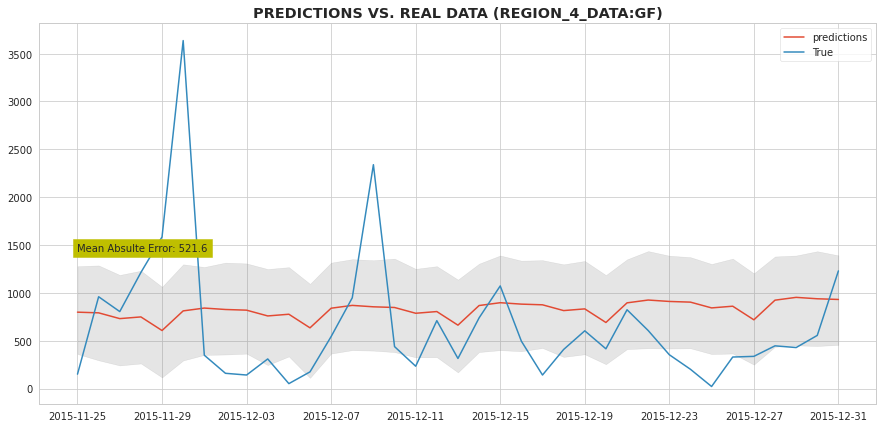

In [45]:
plot_predictions(forecaster,'region_4_data','GF')

In [46]:
payoff = ['2015-1-30',
 '2015-1-31',
 '2015-2-27',
 '2015-2-28',
 '2015-3-30',
 '2015-3-31',
 '2015-4-29',
 '2015-4-30',
 '2015-5-30',
 '2015-5-31',
 '2015-6-29',
 '2015-6-20',
 '2015-7-30',
 '2015-7-31',
 '2015-8-30',
 '2015-8-31',
 '2015-9-29',
 '2015-9-30',
 '2015-10-30',
 '2015-10-31',
 '2015-11-29',
 '2015-11-30',
 '2015-12-30',
 '2015-12-31']

In [47]:
payoff = pd.DataFrame({
  'holiday': 'payoff',
  'ds': pd.to_datetime(payoff),
  'lower_window': 0,
  'upper_window': 1,
})

In [48]:
forecaster = Forecaster(dataset=dataset,holidays=payoff,test_size=0.1)
forecaster.fit(include_history=False,weekly_seasonality='auto',yearly_seasonality=False)

  0%|          | 0/12 [00:00<?, ?it/s]18:35:45 - cmdstanpy - INFO - Chain [1] start processing
18:35:45 - cmdstanpy - INFO - Chain [1] done processing
18:35:46 - cmdstanpy - INFO - Chain [1] start processing
18:35:46 - cmdstanpy - INFO - Chain [1] done processing
18:35:46 - cmdstanpy - INFO - Chain [1] start processing
18:35:46 - cmdstanpy - INFO - Chain [1] done processing
18:35:47 - cmdstanpy - INFO - Chain [1] start processing
18:35:47 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:02<00:24,  2.27s/it]18:35:47 - cmdstanpy - INFO - Chain [1] start processing
18:35:47 - cmdstanpy - INFO - Chain [1] done processing
18:35:48 - cmdstanpy - INFO - Chain [1] start processing
18:35:48 - cmdstanpy - INFO - Chain [1] done processing
18:35:48 - cmdstanpy - INFO - Chain [1] start processing
18:35:49 - cmdstanpy - INFO - Chain [1] done processing
18:35:49 - cmdstanpy - INFO - Chain [1] start processing
18:35:49 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋     

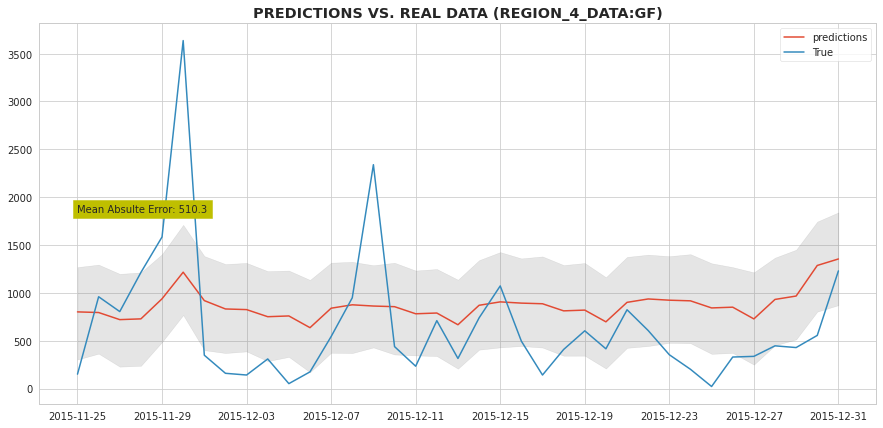

In [49]:
plot_predictions(forecaster,'region_4_data','GF')

In [50]:
## adding sundays as well
payoff_and_sundays = pd.concat([payoff,sundays])
payoff_and_sundays['holiday'] = 'payoff_and_sundays'

In [51]:
forecaster = Forecaster(dataset=dataset,holidays=payoff_and_sundays,test_size=0.1)
forecaster.fit(include_history=False,weekly_seasonality='auto',yearly_seasonality=False)

  0%|          | 0/12 [00:00<?, ?it/s]18:36:14 - cmdstanpy - INFO - Chain [1] start processing
18:36:14 - cmdstanpy - INFO - Chain [1] done processing
18:36:14 - cmdstanpy - INFO - Chain [1] start processing
18:36:14 - cmdstanpy - INFO - Chain [1] done processing
18:36:15 - cmdstanpy - INFO - Chain [1] start processing
18:36:15 - cmdstanpy - INFO - Chain [1] done processing
18:36:16 - cmdstanpy - INFO - Chain [1] start processing
18:36:16 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:03<00:33,  3.05s/it]18:36:17 - cmdstanpy - INFO - Chain [1] start processing
18:36:17 - cmdstanpy - INFO - Chain [1] done processing
18:36:17 - cmdstanpy - INFO - Chain [1] start processing
18:36:17 - cmdstanpy - INFO - Chain [1] done processing
18:36:18 - cmdstanpy - INFO - Chain [1] start processing
18:36:18 - cmdstanpy - INFO - Chain [1] done processing
18:36:19 - cmdstanpy - INFO - Chain [1] start processing
18:36:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋     

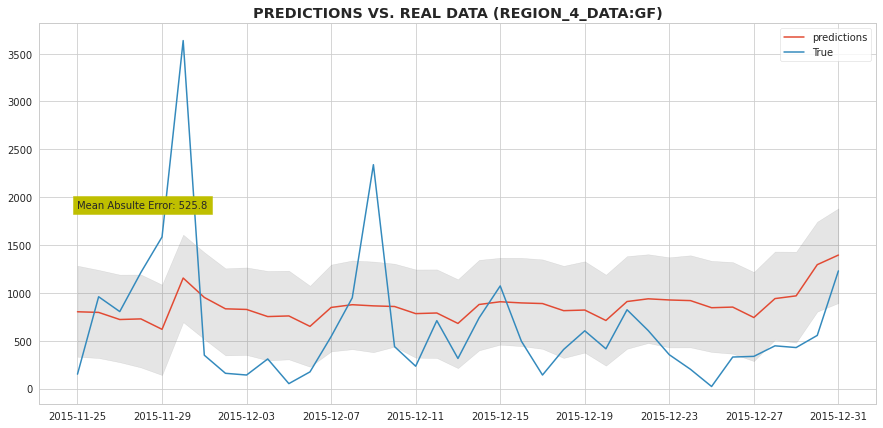

In [52]:
plot_predictions(forecaster,'region_4_data','GF')

## FInal conclusion

- For this dataset, the end of the month hype is really matters. You can see accuracy improvement happed after using that infomation into the modeling.
- Since each region's demand is varible, it's good to do outlier removal at a regional level.